## Домашнее задание «Сегментация и детекция объектов»

Построить классификатор изображений рукописного ввода на базе MNIST.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [51]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [52]:
train_label = train[:,0] # разметка из train в отдельную переменную

In [22]:
# просто посмотреть картинки
train_img = np.reshape(train[:,1:], (len(train[:,1:]), 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

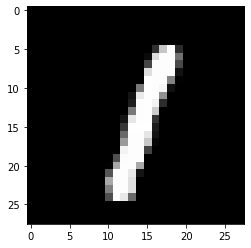

In [45]:
plt.imshow(train_img[25789], cmap='gray');

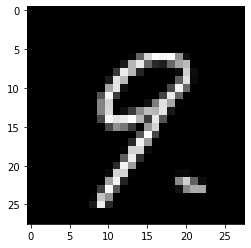

In [139]:
plt.imshow(test_img[2], cmap='gray');

In [57]:
x =  train[:,1:]

In [58]:
# центрирование данных
X_mean = x.mean(axis=0)
x -=X_mean

In [60]:
#матрица ковариации признаков
cov = np.dot(x.T, x)/x.shape[0]
# матрица ковариации должна быть квадратной

In [63]:
U, S, _ = np.linalg.svd(cov)
# U - собственные вектора матрицы ковариации
# S - собственные значения

Мы получили собственные вектора - S (ненулевой вектор , который при умножении на некоторую квадратную матрицу превращается в самого же себя с числовым коэффициентом , называется собственным вектором матрицы). По сути, в собственных вектрах записана информативность.

### Понижение размерности

In [72]:
S_thr = 0.8 # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога

n_comp  = np.argmax(np.where(S_cumsum > S_thr, 1, 0))
print('n comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n comp=42 S=0.800


42 вектора описывают 80 процентов информативности. Картинку раскладываем на 42 собственных вектора и получаем 42 координаты

In [73]:
# получаем сжатое представление объектов
Xrot_reduced = np.dot(x, U [:, : n_comp])

In [74]:
Xrot_reduced.shape

(42000, 42)

In [83]:
Xrot_reduced[0]

array([-661.59577975,  699.31132821,  183.28203965, -120.61139445,
        -81.08181052, -489.46188551, -683.47083797,   85.55938661,
       -348.5480522 , -202.97854522, -364.55994931,   21.26575592,
       -404.44144851,  -97.05254548,   61.83993555,  -86.78002717,
         17.65814358,  285.48469649,   18.82730277,  207.64273128,
         44.24360034,  221.89436971,  -57.22745918, -148.67496175,
         14.34358893,   41.55603106,  333.7236588 , -208.97888078,
        -59.81363057,   84.55446472,   -6.9429306 ,    5.29995065,
       -195.70933579,   53.22922851,   -6.88959872,  146.88658286,
        -49.40662266,   88.06398024, -161.58921015,  140.78761685,
        104.95905976,  -20.03106065])

In [80]:
len(x[0])

784

In [81]:
len(Xrot_reduced[0])

42

количество features снизилось с 784 до 42 (или осталось примерно 6% данных, которые описывают 80% информации)

### Восстановление картинок из собственных векторов (просто посмотреть)

Чтоб визуализировать картинки из собственных векторов, надо восстановить. Перемножаем собственные вектора на матрицу U

In [84]:
Xrot_restored = np.dot(Xrot_reduced, U[:, :n_comp].T)

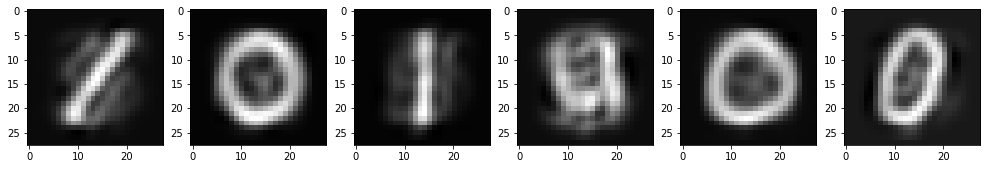

In [87]:
# хоть и для классификации этого не нужно
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(Xrot_restored[0:6], 1):
    subplot = fig.add_subplot(1 , 7, i)
    img_ = img + X_mean
    plt.imshow(img_.reshape((28,28)) + X_mean.reshape((28, 28)), cmap='gray');

### Классификация

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [157]:
model = LogisticRegression(max_iter=42000)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(Xrot_reduced, train_label, test_size=0.3)

In [159]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=42000)

In [160]:
model.predict(X_test)

array([1., 2., 8., ..., 5., 4., 4.])

In [164]:
model.score(X_train, y_train)

0.9064625850340136

In [165]:
model.score(X_test, y_test)

0.9004761904761904

In [167]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      1255
         1.0       0.95      0.97      0.96      1377
         2.0       0.89      0.87      0.88      1257
         3.0       0.87      0.86      0.87      1304
         4.0       0.89      0.91      0.90      1208
         5.0       0.85      0.84      0.84      1130
         6.0       0.93      0.94      0.93      1256
         7.0       0.91      0.92      0.92      1365
         8.0       0.88      0.84      0.86      1235
         9.0       0.86      0.88      0.87      1213

    accuracy                           0.90     12600
   macro avg       0.90      0.90      0.90     12600
weighted avg       0.90      0.90      0.90     12600

